# Applied Data Science Capstone

Notebook for week three of the capstone

In [ ]:
#!conda install -c conda-forge lxml --yes

In [95]:
# import libraries
import pandas as pd
import geocoder
import requests
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium # map rendering library
import numpy as np

## Part 1

Read and clean the data

In [2]:
# read data
df = pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
df = df[0]
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [3]:
# exclude not assigned boroughs
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
df.head(12)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
# look at not assigned neighbourhoods
df[df['Neighbourhood']=='Not assigned']

,Postal Code,Borough,Neighbourhood


No neighbourhoods not assigned

In [5]:
# show shape of dataframe
df.shape

(103, 3)

## Part 2

Get the latitude and Longitude of the postal codes

In [6]:
# define function
def get_latlon(postal_code):
    # initialize variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        lat_lng_coords = g.latlng
    # return result
    return(lat_lng_coords)

In [7]:
# test Geocoder
g = geocoder.google('M7Y, Toronto')
g

<[REQUEST_DENIED] Google - Geocode [empty]>

Googhel API not working - use provided file

In [8]:
# use csv and combine with neighbourhoods
df_latlon = pd.read_csv('https://cocl.us/Geospatial_data')
df = df.merge(df_latlon, how='left', on='Postal Code')
df.head(12)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


In [9]:
# show final size with lats and lons
df.shape

(103, 5)

## Part 3

### Cluster the "Toronto" boroughs

Select only the "Toronto" boroughs

In [10]:
# subset boroughs
df_toronto = df[df['Borough'].str.contains('Toronto')]
print(df_toronto.shape)
df_toronto.head()

(39, 5)


,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031


Extract the venue information for the given postal codes

In [12]:
# read in credentials
cred = pd.read_csv('./FourSquare_Credentials.txt', header=0)
CLIENT_ID = cred.iloc[0, 0]
CLIENT_SECRET = cred.iloc[1, 0]
VERSION = cred.iloc[2, 0]
LIMIT = 100

In [13]:
# use function from previous notebook
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name) 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)  
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    return(nearby_venues)

In [15]:
# run function for Toronto
toronto_venues = getNearbyVenues(df_toronto['Postal Code'], df_toronto['Latitude'], df_toronto['Longitude'])
print(toronto_venues.shape)
toronto_venues.head()

(1624, 7)


,Postal Code,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,M5A,43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,M5A,43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,M5A,43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
3,M5A,43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa
4,M5A,43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Restaurant


Summarise the chracteristics for each postal code

In [19]:
# onehot encode for venue category
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot = toronto_venues[['Postal Code']].merge(toronto_onehot, left_index=True, right_index=True)

# take the average rate of venue category per postal code
toronto_chars = toronto_onehot.groupby('Postal Code').mean().reset_index()
print(toronto_chars.shape)
toronto_chars.head()

(39, 238)


,Postal Code,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,M4E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
1,M4K,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.023256,0.0,...,0.0,0.0,0.023256,0.0,0.0,0.0,0.0,0.000000,0.0,0.023256
2,M4L,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
3,M4M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.054054,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.027027,0.0,0.027027
4,M4N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


Explore the postal codes by their characteristics

In [34]:
# create function to "explore" postal codes
def explore_pc(df_chars, postal_code, topn=5, display=0):
    chars = df_chars[df_chars['Postal Code'] == postal_code].T.reset_index()
    chars.columns = ['Category','Penetration']
    chars = chars.iloc[1:]
    # penetration = percent of venues in pc of given category
    chars['Penetration'] = 100.0*chars['Penetration'].astype(float) 
    chars = chars.round({'Penetration': 1})
    top_categories = chars.sort_values('Penetration', ascending=False).reset_index(drop=True).head(topn)
    # if display requested then print results
    if display==1:
        print("----"+postal_code+"----")
        print(top_categories)
        print('\n')
    # for use in profiling
    return(top_categories)

In [35]:
# explore all postal codes
pc_to_explore = list(toronto_chars['Postal Code'])

# for brevity limit exploration to top 10 for only M4K and M4M
pc_to_explore = ['M4K', 'M4M']
for pc in pc_to_explore:
    explore_pc(toronto_chars, pc, topn=10, display=1)

----M4K----
                  Category  Penetration
0         Greek Restaurant         16.3
1              Coffee Shop          9.3
2       Italian Restaurant          7.0
3   Furniture / Home Store          4.7
4                Bookstore          4.7
5           Ice Cream Shop          4.7
6               Restaurant          4.7
7                   Lounge          2.3
8  Fruit & Vegetable Store          2.3
9                      Spa          2.3


----M4M----
                  Category  Penetration
0              Coffee Shop          8.1
1                  Brewery          5.4
2                     Café          5.4
3      American Restaurant          5.4
4                   Bakery          5.4
5                Gastropub          5.4
6                  Gay Bar          2.7
7              Cheese Shop          2.7
8           Clothing Store          2.7
9  Comfort Food Restaurant          2.7




Use the top 10 venue categories to profile the postal codes

In [54]:
# create profile of each postal code using top 10 categories
top_n = 10
toronto_profile = []
suffix = ['st', 'nd', 'rd']+['th']*top_n

# get top 10 categories for each postal code
for pc in list(toronto_chars['Postal Code']):
    topn = explore_pc(toronto_chars, pc, topn=top_n)
    topn = [pc]+list(topn['Category'])
    toronto_profile.append(topn)
    
# convert results to dataframe
toronto_profile = pd.DataFrame(toronto_profile)
toronto_profile.columns = ['Postal Code'] + [f'{str(x+1)}{suffix[x]} Most Common Category' for x in range(top_n)]
    
toronto_profile

,Postal Code,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,M4E,Trail,Health Food Store,Neighborhood,Pub,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Afghan Restaurant
1,M4K,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Bookstore,Ice Cream Shop,Restaurant,Lounge,Fruit & Vegetable Store,Spa
2,M4L,Park,Coffee Shop,Brewery,Fast Food Restaurant,Fish & Chips Shop,Liquor Store,Sandwich Place,Restaurant,Steakhouse,Movie Theater
3,M4M,Coffee Shop,Brewery,Café,American Restaurant,Bakery,Gastropub,Gay Bar,Cheese Shop,Clothing Store,Comfort Food Restaurant
4,M4N,Park,Bus Line,Swim School,Afghan Restaurant,Monument / Landmark,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store
5,M4P,Gym / Fitness Center,Food & Drink Shop,Dance Studio,Department Store,Dog Run,Sandwich Place,Breakfast Spot,Park,Hotel,Hotel Bar
6,M4R,Coffee Shop,Clothing Store,Yoga Studio,Bagel Shop,Diner,Restaurant,Chinese Restaurant,Salon / Barbershop,Café,Mexican Restaurant
7,M4S,Pizza Place,Dessert Shop,Sandwich Place,Café,Coffee Shop,Italian Restaurant,Sushi Restaurant,Gym,Farmers Market,Park
8,M4T,Playground,Trail,Afghan Restaurant,Movie Theater,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant
9,M4V,Coffee Shop,Light Rail Station,Pub,Liquor Store,Fried Chicken Joint,Supermarket,Sushi Restaurant,Bank,Restaurant,Bagel Shop


Cluster the postal codes

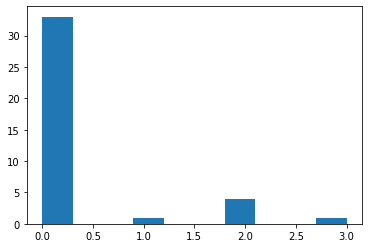

In [78]:
# set number of clusters
kclusters = 4

# run k-means clustering
toronto_cluster = toronto_chars[toronto_chars.columns[1:]]
toronto_kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_cluster)

# check cluster sizes generated

plt.hist(toronto_kmeans.labels_);

The majority of postal codes fit within the same cluster

Bring all the results together and display with profiles

In [83]:
# merge segment with postal code details
toronto_segments = pd.DataFrame(toronto_kmeans.labels_, columns=['Segment']).reset_index(drop=True).join(df_toronto.reset_index(drop=True))

# merge segment and post code with profile
toronto_segments = toronto_segments.merge(toronto_profile, on='Postal Code')

toronto_segments

,Segment,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Theater,Café,Event Space,Brewery,Chocolate Shop
1,0,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Coffee Shop,Yoga Studio,Chinese Restaurant,Sushi Restaurant,Beer Bar,Fried Chicken Joint,Smoothie Shop,Mexican Restaurant,Café,Sandwich Place
2,0,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,Clothing Store,Coffee Shop,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Theater,Bookstore,Fast Food Restaurant,Ramen Restaurant
3,0,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,Coffee Shop,Café,Cocktail Bar,Restaurant,American Restaurant,Gastropub,Beer Bar,Lingerie Store,Clothing Store,Gym
4,2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Trail,Health Food Store,Neighborhood,Pub,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Afghan Restaurant
5,0,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,Coffee Shop,Cocktail Bar,Beer Bar,Farmers Market,Cheese Shop,Bakery,Seafood Restaurant,Restaurant,Liquor Store,Sporting Goods Shop
6,0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,Coffee Shop,Café,Sandwich Place,Italian Restaurant,Thai Restaurant,Bubble Tea Shop,Burger Joint,Salad Place,Japanese Restaurant,Department Store
7,0,M6G,Downtown Toronto,Christie,43.669542,-79.422564,Grocery Store,Café,Park,Coffee Shop,Italian Restaurant,Baby Store,Restaurant,Athletics & Sports,Nightclub,Candy Store
8,3,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Coffee Shop,Café,Restaurant,Gym,Bar,Clothing Store,Thai Restaurant,Hotel,Office,Pizza Place
9,0,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,Bakery,Pharmacy,Middle Eastern Restaurant,Brewery,Bar,Music Venue,Supermarket,Café,Bank,Grocery Store


Visualise the segments on a map

In [117]:
# create map
segments_map = folium.Map(location=[toronto_segments['Latitude'].mean(), toronto_segments['Longitude'].mean()], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.Dark2(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_segments['Latitude'], toronto_segments['Longitude'], toronto_segments['Neighbourhood'], toronto_segments['Segment']):
    label = folium.Popup(str(poi) + ': Segment ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color='k', #rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(segments_map)

segments_map

Review the smaller segments

In [118]:
# look at segment 1
toronto_segments[toronto_segments['Segment']==1]

,Segment,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
22,1,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,Café,Mexican Restaurant,Bar,Thai Restaurant,Park,Italian Restaurant,Cajun / Creole Restaurant,Fried Chicken Joint,Speakeasy,Bookstore


In [119]:
# look at segment 2
toronto_segments[toronto_segments['Segment']==2]

,Segment,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
0,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Coffee Shop,Pub,Bakery,Park,Breakfast Spot,Theater,Café,Event Space,Brewery,Chocolate Shop
4,2,M4E,East Toronto,The Beaches,43.676357,-79.293031,Trail,Health Food Store,Neighborhood,Pub,Mexican Restaurant,Molecular Gastronomy Restaurant,Modern European Restaurant,Miscellaneous Shop,Middle Eastern Restaurant,Afghan Restaurant
10,2,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752,Coffee Shop,Aquarium,Café,Hotel,Brewery,Scenic Lookout,Restaurant,Fried Chicken Joint,Pizza Place,Plaza
23,2,M4R,Central Toronto,"North Toronto West, Lawrence Park",43.715383,-79.405678,Coffee Shop,Clothing Store,Yoga Studio,Bagel Shop,Diner,Restaurant,Chinese Restaurant,Salon / Barbershop,Café,Mexican Restaurant


In [120]:
# look at segment 3
toronto_segments[toronto_segments['Segment']==3]

,Segment,Postal Code,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category,8th Most Common Category,9th Most Common Category,10th Most Common Category
8,3,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,Coffee Shop,Café,Restaurant,Gym,Bar,Clothing Store,Thai Restaurant,Hotel,Office,Pizza Place
